# Trial 2 Undergraduate Thesis
Goal :
- Create XGBoost and Linear Regresion Model
- Get insights from the datas
- Get the best blanket configuration

Name : Husni Naufal Zuhdi (413821)

## Regression with XGBoost

In [1]:
# Basic Numerical Packages
import numpy as np
import pandas as pd
import csv as csv
import os

# Ploting Packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

# XGBoost and Machine Learning related Packages
import xgboost as xgb
from xgboost import plot_importance
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import skew
from collections import OrderedDict

# Download files from Cloud Storage

In [2]:
# Set Cloud Storage Service Account
from google.cloud import storage
client = storage.Client.from_service_account_json(
    'key.json', project='iter-tritium-breeding-xgboost'
)

In [3]:
# Set variables of result file
enrich_lis = [0.1, 0.3, 0.5, 0.7, 0.9]
mod_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
neutron_multis = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
bucket = client.bucket("iter-tritium-breeding-xgboost-bucket") # Your bucket name
result_uri = "v3/results/" # Result.json files uri

# Download all result.json file in Cloud Storage Bucket
for enrich_li in enrich_lis:
    for mod_ratio in mod_ratios:
        for neutron_multi in neutron_multis:
            try:
                print("Downloading : " + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-20-5000.json")
                blob = bucket.blob(result_uri + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-20-5000.json")
                blob.download_to_filename("result/" + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-20-5000.json")
            except Exception:
                pass

# Build Dataframe from Downloaded Files

In [2]:
# Read folder contain simulation results
path = "/home/ubuntu/iter-tritium-breeding-xgboost/jupyter-notebooks/2-data-analysis/result"
results = os.listdir(path=path)
results.sort()

In [3]:
# Read data in each folder
data = []
for result in results:
    # Find enrichment feature
    folder_path = path + str(result)
    folder_list = result.split('-')
    folder_list = folder_list[0:3]
    
    # Read tbr and std dev data
    try:
        json_result = pd.read_json(path + "/" + result)
        json_result = json_result["blanket_fluid_mat_(n,Xt)"]["events per source particle"]
        data.append([folder_list[0], folder_list[1], folder_list[2], json_result['result'], json_result['std. dev.']])
    except Exception:
        pass

# Build dataframe from simulation data
df = pd.DataFrame(data, columns=['Li6_enrichment', 'Moderator_ratio','Neutron_multiplier', 'Tbr_OpenMC', 'Stddev'])

# Convert all dataframe type from string into float
df.Li6_enrichment = df.Li6_enrichment.astype(float)
df.Moderator_ratio = df.Moderator_ratio.astype(float)
df.Neutron_multiplier = df.Neutron_multiplier.astype(float)

# Exploratory Data Analysis

In [4]:
# Build an excel file for design without moderator and neutron multiplier
df_first = df.loc[(df["Moderator_ratio"] == 0.0) & (df["Neutron_multiplier"] == 0.0)]
# datatoexcel = pd.ExcelWriter('df_first.xlsx')
# df_first.to_excel(datatoexcel)
# datatoexcel.save()

[Text(0.5, 0, 'Pengayaan Litium-6 (%)'), Text(0, 0.5, 'TBR')]

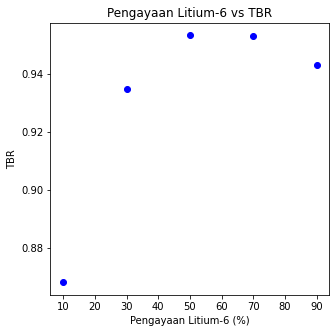

In [5]:
# Plot each 6Li vs TBR for df_first
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(df_first.Li6_enrichment*100, df_first.Tbr_OpenMC, c = "blue", marker = "o")
ax.set_title("Pengayaan Litium-6 vs TBR")
ax.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
# plt.savefig('df_first_enrich.png')

In [6]:
# Build an excel file for design with moderator without neutron multiplier
df_second = df.loc[(df["Neutron_multiplier"] == 0.0) & (df["Moderator_ratio"] != 0.0)]
# datatoexcel = pd.ExcelWriter('df_second.xlsx')
# df_second.to_excel(datatoexcel)
# datatoexcel.save()

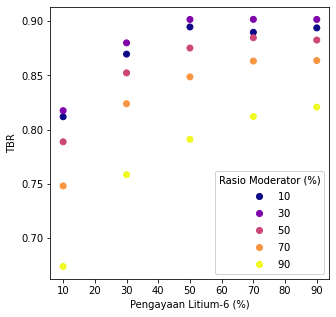

In [8]:
# Plot each 6Li vs TBR for df_second
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
scatter = ax.scatter(df_second.Li6_enrichment*100, df_second.Tbr_OpenMC, c = df_second.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
legend = ax.legend(*scatter.legend_elements(), loc="lower right", title="Rasio Moderator (%)", fontsize=10)
ax.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax.add_artist(legend)
plt.savefig('df_second.png')

In [9]:
# Build an excel file for design with moderator and neutron multiplier
df_third = df.loc[(df["Neutron_multiplier"] != 0.0) & (df["Moderator_ratio"] != 0.0)]
# datatoexcel = pd.ExcelWriter('df_third.xlsx')
# df_third.to_excel(datatoexcel)
# datatoexcel.save()

In [10]:
df_third_1 = df.loc[(df["Neutron_multiplier"] == 0.1) & (df["Moderator_ratio"] != 0.0)]
df_third_3 = df.loc[(df["Neutron_multiplier"] == 0.3) & (df["Moderator_ratio"] != 0.0)]
df_third_5 = df.loc[(df["Neutron_multiplier"] == 0.5) & (df["Moderator_ratio"] != 0.0)]
df_third_7 = df.loc[(df["Neutron_multiplier"] == 0.7) & (df["Moderator_ratio"] != 0.0)]
df_third_9 = df.loc[(df["Neutron_multiplier"] == 0.9) & (df["Moderator_ratio"] != 0.0)]

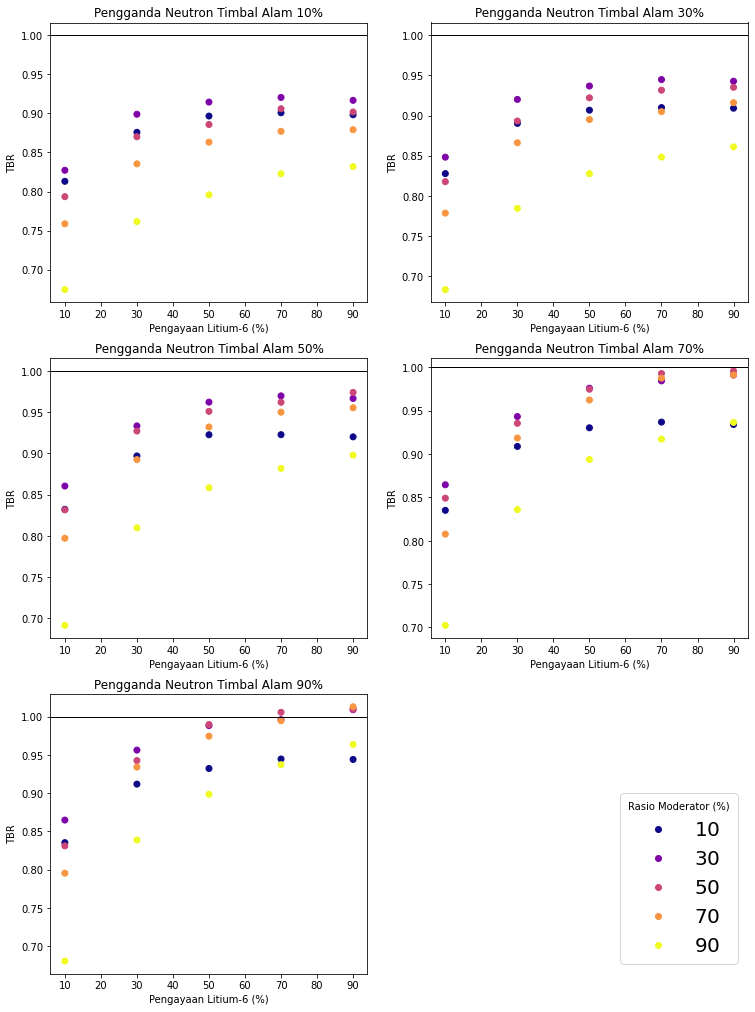

In [12]:
# Plot each 6Li vs TBR for df_third
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12.5, 17.5))

# AX1
scatter = ax1.scatter(df_third_1.Li6_enrichment*100, df_third_1.Tbr_OpenMC, c = df_third_1.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax1.set_title("Pengganda Neutron Timbal Alam 10%")
ax1.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax1.axhline(y=1, linewidth=1, color='k')

# AX2
scatter = ax2.scatter(df_third_3.Li6_enrichment*100, df_third_3.Tbr_OpenMC, c = df_third_3.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax2.set_title("Pengganda Neutron Timbal Alam 30%")
ax2.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax2.axhline(y=1, linewidth=1, color='k')

# AX3
scatter = ax3.scatter(df_third_5.Li6_enrichment*100, df_third_5.Tbr_OpenMC, c = df_third_5.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax3.set_title("Pengganda Neutron Timbal Alam 50%")
ax3.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax3.axhline(y=1, linewidth=1, color='k')

# AX4
scatter = ax4.scatter(df_third_7.Li6_enrichment*100, df_third_7.Tbr_OpenMC, c = df_third_7.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax4.set_title("Pengganda Neutron Timbal Alam 70%")
ax4.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax4.axhline(y=1, linewidth=1, color='k')

# AX5
scatter = ax5.scatter(df_third_9.Li6_enrichment*100, df_third_9.Tbr_OpenMC, c = df_third_9.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax5.set_title("Pengganda Neutron Timbal Alam 90%")
ax5.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax5.axhline(y=1, linewidth=1, color='k')

# AX6
ax6.axis('off')
legend = plt.legend(*scatter.legend_elements(), loc="lower right", title="Rasio Moderator (%)", prop={'size': 20})
plt.savefig('df_third.png')

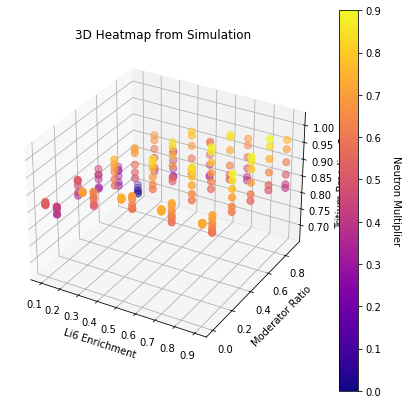

In [13]:
# Read the dataset
x = df["Li6_enrichment"].tolist()
y = df["Moderator_ratio"].tolist()
z = df["Tbr_OpenMC"].tolist()

colo = df["Neutron_multiplier"].tolist()

# Creating 3d figures
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.plasma)
color_map.set_array(colo)

# Creating the heatmap
img = ax.scatter(x, y, z, marker='o', s=50, c=z, cmap=cm.plasma)
heatmap = plt.colorbar(color_map)
heatmap.set_label('Neutron Multiplier', rotation=270, labelpad=20)

# Adding title and labels
ax.set_title("3D Heatmap from Simulation")
ax.set_xlabel('Li6 Enrichment')
ax.set_ylabel('Moderator Ratio')
ax.set_zlabel('Tritium Breeding Ratio')

# Displaying plot
plt.show()

In [14]:
# See the best blanket design
df.sort_values(by=['Tbr_OpenMC'], ascending=False).head(10)

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr_OpenMC,Stddev
173,0.9,0.7,0.9,1.012842,0.004387
167,0.9,0.5,0.9,1.009560,0.003302
161,0.9,0.3,0.9,1.008993,0.003505
131,0.7,0.5,0.9,1.005552,0.004294
125,0.7,0.3,0.9,0.995924,0.003419
166,0.9,0.5,0.7,0.995918,0.003552
137,0.7,0.7,0.9,0.994566,0.003919
130,0.7,0.5,0.7,0.993001,0.005239
160,0.9,0.3,0.7,0.991248,0.003629
172,0.9,0.7,0.7,0.991240,0.004500


# Preprocessing

In [8]:
# Split dataset into train and test datasets
features_columns = [col for col in df.columns if col not in ['Tbr_OpenMC', 'Stddev']]
X_train, X_test, y_train, y_test = train_test_split(df[features_columns],df['Tbr_OpenMC'],test_size=.5, random_state=42)

In [9]:
# Load data into DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Build Machine Learning Model

## Set Initial Hyperparameters

In [11]:
# First hyperparameters
params = {
    # Parameters that we are going to tune.
    'max_depth':5,
    'min_child_weight': 1,
    'eta':.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':['rmse', 'mae'],
}

In [12]:
# First Model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtrain, "Train"), (dtest, "Test")],
#     early_stopping_rounds=10
)

[0]	Train-rmse:0.36575	Train-mae:0.36037	Test-rmse:0.35659	Test-mae:0.34986
[1]	Train-rmse:0.33055	Train-mae:0.32521	Test-rmse:0.32201	Test-mae:0.31529
[2]	Train-rmse:0.29887	Train-mae:0.29348	Test-rmse:0.29090	Test-mae:0.28410
[3]	Train-rmse:0.27032	Train-mae:0.26471	Test-rmse:0.26214	Test-mae:0.25495
[4]	Train-rmse:0.24461	Train-mae:0.23890	Test-rmse:0.23723	Test-mae:0.23002
[5]	Train-rmse:0.22147	Train-mae:0.21559	Test-rmse:0.21398	Test-mae:0.20644
[6]	Train-rmse:0.20056	Train-mae:0.19494	Test-rmse:0.19367	Test-mae:0.18638
[7]	Train-rmse:0.18171	Train-mae:0.17617	Test-rmse:0.17525	Test-mae:0.16790
[8]	Train-rmse:0.16475	Train-mae:0.15909	Test-rmse:0.15829	Test-mae:0.15070
[9]	Train-rmse:0.14948	Train-mae:0.14375	Test-rmse:0.14347	Test-mae:0.13585
[10]	Train-rmse:0.13568	Train-mae:0.12984	Test-rmse:0.13025	Test-mae:0.12242
[11]	Train-rmse:0.12320	Train-mae:0.11740	Test-rmse:0.11825	Test-mae:0.11031
[12]	Train-rmse:0.11198	Train-mae:0.10611	Test-rmse:0.10743	Test-mae:0.09942
[13]	Trai

In [41]:
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best RMSE: 0.02 with 102 rounds


In [42]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.365921,0.003169,0.365644,0.014005
1,0.330890,0.002845,0.330520,0.013977
2,0.299311,0.002546,0.299056,0.013837
3,0.270855,0.002267,0.270743,0.013406
4,0.245220,0.002030,0.245131,0.012969
...,...,...,...,...
121,0.001724,0.000054,0.011236,0.001032
122,0.001724,0.000054,0.011236,0.001032
123,0.001724,0.000054,0.011236,0.001031
124,0.001724,0.000054,0.011236,0.001031


In [43]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,11)
    for min_child_weight in range(1,11)
]

# Define initial best params and RMSE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=1, min_child_weight=1
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=2
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=3
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=4
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=5
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=6
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=7
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=8
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=9
	RMSE 0.026076 for 416 rounds
CV with max_depth=1, min_child_weight=10
	RMSE 0.026069 for 547 rounds
CV with max_depth=2, min_child_weight=1
	RMSE 0.0133904 for 130 rounds
CV with max_depth=2, min_child_weight=2
	RMSE 0.012867400000000001 for 150 rounds
CV with max_depth=2, min_child_weight=3
	RMSE 0.013076599999999999 for 239 rounds
CV with max_depth=2, min_child_weight=4
	RMSE 0.0146266 for 190 

In [44]:
# Update first and second parameters
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

In [45]:
gridsearch_params = [
    (subsample, colsample, gamma)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(6,11)]
    for gamma in [i/10. for i in range(0,6)]
]

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample, gamma in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}, gamma={}".format(
        subsample,
        colsample,
        gamma))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    params['gamma'] = gamma
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample,gamma)
print("Best params: {}, {}, {}, RMSE: {}".format(best_params[0], best_params[1], best_params[2], min_rmse))

CV with subsample=1.0, colsample=1.0, gamma=0.5
	RMSE 0.0668218 for 100 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.4
	RMSE 0.0668218 for 100 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.3
	RMSE 0.0668218 for 100 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.2
	RMSE 0.0668218 for 100 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.1
	RMSE 0.06448279999999999 for 105 rounds
CV with subsample=1.0, colsample=1.0, gamma=0.0
	RMSE 0.0092056 for 276 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.5
	RMSE 0.0668218 for 100 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.4
	RMSE 0.0668218 for 100 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.3
	RMSE 0.0668218 for 100 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.2
	RMSE 0.0668218 for 100 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.1
	RMSE 0.06448499999999999 for 105 rounds
CV with subsample=1.0, colsample=0.9, gamma=0.0
	RMSE 0.014494400000000001 for 299 rounds
CV with subsample=1.0

In [46]:
# Update third and fourth parameters
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]
params['gamma'] = best_params[2]

In [47]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [0, 1e-5, 1e-2, 0.1, 1, 10, 100]

# Define initial best params and RMSE
min_rmse = float("Inf")
best_params = None
for reg_alpha in gridsearch_params:
    print("CV with reg_alpha={}".format(reg_alpha))
    # Update our parameters
    params['reg_alpha'] = reg_alpha
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = reg_alpha
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with reg_alpha=0
	RMSE 0.0088196 for 228 rounds
CV with reg_alpha=1e-05
	RMSE 0.008795800000000001 for 228 rounds
CV with reg_alpha=0.01
	RMSE 0.0101298 for 294 rounds
CV with reg_alpha=0.1
	RMSE 0.0165576 for 362 rounds
CV with reg_alpha=1
	RMSE 0.0398238 for 348 rounds
CV with reg_alpha=10
	RMSE 0.1586298 for 349 rounds
CV with reg_alpha=100
	RMSE 0.4045934 for 0 rounds
Best params: 1e-05, RMSE: 0.008795800000000001


In [48]:
# Update reg_alpha parameters
params['reg_alpha'] = best_params

In [49]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [0.01, 0.05, 0.07, 0.1, 0.3, 0.5]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=999,seed=42,nfold=5,metrics=['rmse'],early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs
CV with eta=0.01
CPU times: user 25.4 s, sys: 22.8 ms, total: 25.4 s
Wall time: 1.59 s
	RMSE 0.0103978 for 998 rounds

CV with eta=0.05
CPU times: user 12.5 s, sys: 21.9 ms, total: 12.5 s
Wall time: 787 ms
	RMSE 0.0087338 for 481 rounds

CV with eta=0.07
CPU times: user 7.99 s, sys: 11.5 ms, total: 8 s
Wall time: 504 ms
	RMSE 0.009371400000000002 for 295 rounds

CV with eta=0.1
CPU times: user 6.09 s, sys: 20.6 ms, total: 6.11 s
Wall time: 387 ms
	RMSE 0.008795800000000001 for 228 rounds

CV with eta=0.3
CPU times: user 1.3 s, sys: 5.45 ms, total: 1.3 s
Wall time: 86.5 ms
	RMSE 0.009167400000000001 for 41 rounds

CV with eta=0.5
CPU times: user 1.42 s, sys: 9.27 ms, total: 1.43 s
Wall time: 91.3 ms
	RMSE 0.011665600000000002 for 44 rounds

Best params: 0.05, RMSE: 0.0087338


In [50]:
# Update fifth parameters
params['eta'] = best_params

In [51]:
new_model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-rmse:0.37594
[1]	Test-rmse:0.35776
[2]	Test-rmse:0.34056
[3]	Test-rmse:0.32413
[4]	Test-rmse:0.30851
[5]	Test-rmse:0.29358
[6]	Test-rmse:0.27957
[7]	Test-rmse:0.26588
[8]	Test-rmse:0.25301
[9]	Test-rmse:0.24090
[10]	Test-rmse:0.22925
[11]	Test-rmse:0.21826
[12]	Test-rmse:0.20764
[13]	Test-rmse:0.19764
[14]	Test-rmse:0.18834
[15]	Test-rmse:0.17919
[16]	Test-rmse:0.17084
[17]	Test-rmse:0.16280
[18]	Test-rmse:0.15518
[19]	Test-rmse:0.14766
[20]	Test-rmse:0.14070
[21]	Test-rmse:0.13412
[22]	Test-rmse:0.12788
[23]	Test-rmse:0.12198
[24]	Test-rmse:0.11635
[25]	Test-rmse:0.11119
[26]	Test-rmse:0.10618
[27]	Test-rmse:0.10126
[28]	Test-rmse:0.09684
[29]	Test-rmse:0.09242
[30]	Test-rmse:0.08834
[31]	Test-rmse:0.08452
[32]	Test-rmse:0.08058
[33]	Test-rmse:0.07696
[34]	Test-rmse:0.07354
[35]	Test-rmse:0.07029
[36]	Test-rmse:0.06708
[37]	Test-rmse:0.06409
[38]	Test-rmse:0.06129
[39]	Test-rmse:0.05867
[40]	Test-rmse:0.05633
[41]	Test-rmse:0.05385
[42]	Test-rmse:0.05148
[43]	Test-rmse:0.0493

In [52]:
# Build a validation dataframe
data_val = []
enrich = [round(0.02*x,2) for x in range(1,51)]
nm = [round(0.02*x,2) for x in range(1,51)]
mod = [round(0.02*x,2) for x in range(1,51)]
for i in enrich:
    for j in mod:
        for k in nm:
            data_val.append([i, j, k, 0, 0])
            
df_val = pd.DataFrame(data_val,
                      columns=['Li6_enrichment',
                               'Moderator_ratio',
                               'Neutron_multiplier',
                               'Tbr_XGBoost',
                               'Tbr_OpenMC'
                              ]
                     )

In [53]:
# # Move TBR_OpenMC in df dataframe into d_val dataframe
# for i in enrich:
#     for j in mod:
#         for k in nm:
#             try:
#                 tbr_row = df.loc[(df["Li6_enrichment"] == i) & (df["Moderator_ratio"] == j) & (df["Neutron_multiplier"] == k)]
#                 tbr_row = tbr_row['Tbr_OpenMC']
#                 tbr_row = tbr_row.to_numpy()

#                 tbr_ml_row = df_val.loc[(df_val["Li6_enrichment"] == i) & (df_val["Moderator_ratio"] == j) & (df_val["Neutron_multiplier"] == k)]
#                 df_val.iloc[tbr_ml_row.index, 4] = tbr_row[0]
#                 print("Move TBR_OpenMC " + str(i) + str(j) + str(k) + " in df dataframe into d_val dataframe")
#             except Exception:
#                 pass

In [54]:
# Make predictions with best model for validation data
features_columns = ['Li6_enrichment', 'Moderator_ratio', 'Neutron_multiplier']
dval = xgb.DMatrix(df_val[features_columns])
y_pred = new_model.predict(dval)
df_val['Tbr_XGBoost'] = y_pred

In [55]:
df_val.sort_values(by=['Tbr_XGBoost'], ascending=False).head(20)

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr_XGBoost,Tbr_OpenMC
108940,0.88,0.58,0.82,1.008641,0
103699,0.84,0.48,1.00,1.008641,0
103690,0.84,0.48,0.82,1.008641,0
103691,0.84,0.48,0.84,1.008641,0
103692,0.84,0.48,0.86,1.008641,0
103693,0.84,0.48,0.88,1.008641,0
103694,0.84,0.48,0.90,1.008641,0
103695,0.84,0.48,0.92,1.008641,0
103696,0.84,0.48,0.94,1.008641,0
103697,0.84,0.48,0.96,1.008641,0


[Text(0.5, 0, 'Neutron Multiplier (%)')]

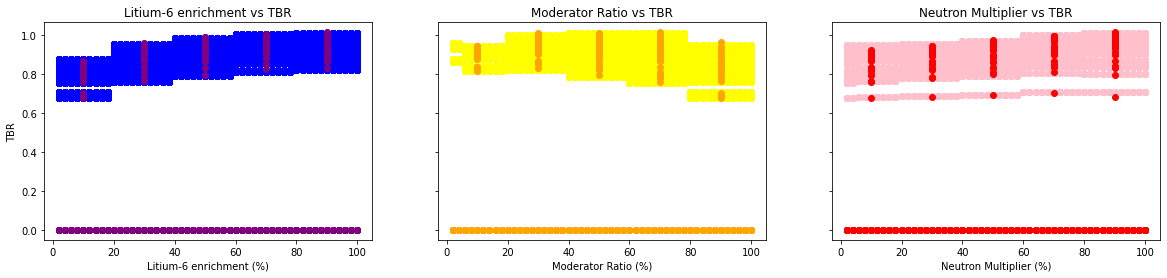

In [34]:
# Plot each features vs TBR
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 4))
ax1.scatter(df_val.Li6_enrichment*100, df_val.Tbr_XGBoost, c = "blue", marker = "o")
ax1.scatter(df_val.Li6_enrichment*100, df_val.Tbr_OpenMC, c = "purple", marker = "o")
ax1.set_title("Litium-6 enrichment vs TBR")
ax1.set(xlabel='Litium-6 enrichment (%)', ylabel='TBR')
ax2.scatter(df_val.Moderator_ratio*100, df_val.Tbr_XGBoost, c = "yellow", marker = "o")
ax2.scatter(df_val.Moderator_ratio*100, df_val.Tbr_OpenMC, c = "orange", marker = "o")
ax2.set_title("Moderator Ratio vs TBR")
ax2.set(xlabel='Moderator Ratio (%)')
ax3.scatter(df_val.Neutron_multiplier*100, df_val.Tbr_XGBoost, c = "pink", marker = "o")
ax3.scatter(df_val.Neutron_multiplier*100, df_val.Tbr_OpenMC, c = "red", marker = "o")
ax3.set_title("Neutron Multiplier vs TBR")
ax3.set(xlabel='Neutron Multiplier (%)')

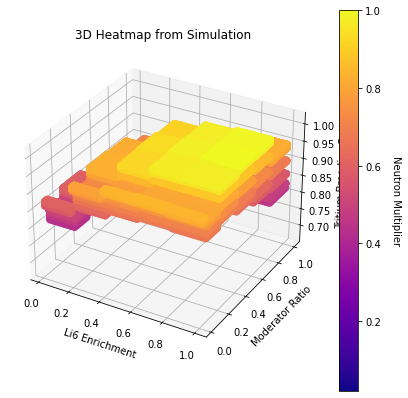

In [35]:
# Read the dataset
x = df_val["Li6_enrichment"].tolist()
y = df_val["Moderator_ratio"].tolist()
z = df_val["Tbr_XGBoost"].tolist()

colo = df_val["Neutron_multiplier"].tolist()

# Creating 3d figures
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.plasma)
color_map.set_array(colo)

# Creating the heatmap
img = ax.scatter(x, y, z, marker='o', s=50, c=z, cmap=cm.plasma)
heatmap = plt.colorbar(color_map)
heatmap.set_label('Neutron Multiplier', rotation=270, labelpad=20)

# Adding title and labels
ax.set_title("3D Heatmap from Simulation")
ax.set_xlabel('Li6 Enrichment')
ax.set_ylabel('Moderator Ratio')
ax.set_zlabel('Tritium Breeding Ratio')

# Displaying plot
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

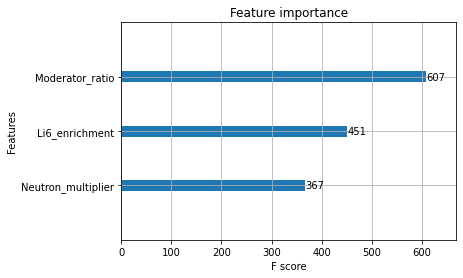

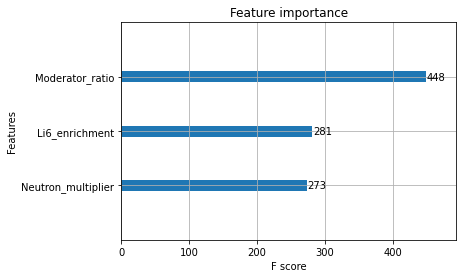

In [36]:
xgb.plot_importance(model)
xgb.plot_importance(new_model)